# Parsing 1000Z Rigol Waveforms

**Scott Prahl**

**Feb 2020**

## Introduction

The goal of this notebook is to explain the origins of the raw data to voltage conversion on the Rigol 1000z scope `.wfm` files.

- DS1054Z
- DS1074Z Plus
- DS1074Z-S Plus
- DS1104Z Plus
- DS1104Z-S Plus

The file format extracts the `volts_per_division` and `volts_offset` values, but using these with raw data required reading the [Rigol Programming Guide](https://www.batronix.com/pdf/Rigol/ProgrammingGuide/MSO1000Z_DS1000Z_ProgrammingGuide_EN.pdf) for the DS1000Z.

Two different `.wfm` files are examined, one for the MS01102 and one for DS1074Z

**There is still something screwy about the conversion of raw bytes to volts.**

In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt

try:
    import RigolWFM.wfme as wfme

except:
    print("***** You need to install the module to read Rigol files first *****")
    print("***** Execute the following line in a new cell, then retry     *****")
    print()
    print("!{sys.executable} -m pip install RigolWFM")

## Background on the voltage and time conversions.

It is bit confusing because the `.wfm` files and the `.csv` files can differ.  I think that the `.wfm` files always correspond to the scope's `RAW` mode and the `.csv` files can be limited to just the display or `NORMAL` mode.

### Voltage conversion

From the [Rigol Programming Guide](https://www.batronix.com/pdf/Rigol/ProgrammingGuide/MSO1000Z_DS1000Z_ProgrammingGuide_EN.pdf)
    
page 2-221::
>    volts = (raw_byte - YORigin - YREFerence) * YINCrement

page 2-223, assuming `RAW` mode::
>    YINCrement = VerticalScale/25

>    YORigin = VerticalOffset/YINCrement

>    YREFerence is always 127
    
So this becomes::
>    volts = (raw_byte - VerticalOffset/YINCrement - 127) * YINCrement

>    volts = (raw_byte - 127) * YINCrement - VerticalOffset

>    volts = (raw_byte - 127.0) * VerticalScale/25.0 - VerticalOffset

Where the decimal points are needed to force python to do all math with floats.

### Time Conversions

On page 2-222 we find that

`XINCrement` the time difference between two neighboring points of the specified channel source in the X direction and

> XINCrement = 1/SampleRate

on the other hand, when the scope is in `NORMAL` mode or display mode, then

> XINCrement = TimeScale/100

`XORigin` is the start time of the waveform data of the channel source currently selected in the X direction.

Both should be in seconds.

## Start with waveform with a single trace

Start with a `.wfm` file from a Rigol MSO1104 scope.

First let's look at the description of the internal file structure. We see that only channel 1 has been enabled.

In [2]:
# raw=true is needed because this is a binary file
wfm_filename = "https://github.com/scottprahl/RigolWFM/raw/master/wfm/MSO1104.wfm" + "?raw=true"  

channels = wfme.read_and_parse_file(wfm_filename, kind='1000Z')

for ch in channels:
    print(ch)

working on https://github.com/scottprahl/RigolWFM/raw/master/wfm/MSO1104.wfm?raw=true
downloading file
Channel 1
    Enabled:   True
    Voltage:
        Scale  = 5 V/div
        Offset = 400 mV
    Time:
        Scale  = 1 ms/div
        Delay  = -200 ps
        Delta  = 1000 ns/point
    Data:
        Points = 1200512
        Raw    = [      174,      175,      176  ...        70,       70]
        Volts  = [    9.8 V,     10 V,   10.2 V  ...     -11 V,    -11 V]
        Times  = [-600.256 ms,-600.255 ms,-600.254 ms  ... 600.255 ms,600.256 ms]



There are a lot of points, so just look the first and last 500 bytes in the `.wfm` file. It looks like the signal is a nice sinusoid at the start and at the end.  Since the waveform does not have a corresponding `.csv` file

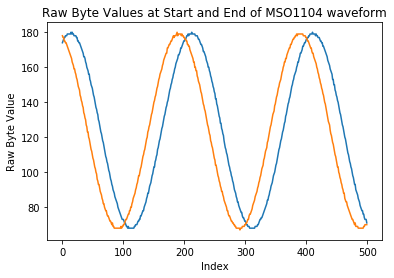

In [3]:
plt.plot(channels[0].raw[:500])
plt.plot(channels[0].raw[-500:])

plt.xlabel("Index")
plt.ylabel("Raw Byte Value")

plt.title("Raw Byte Values at Start and End of MSO1104 waveform")
plt.show()

Trying to create a function to convert to volts.  This one is at least plausible.

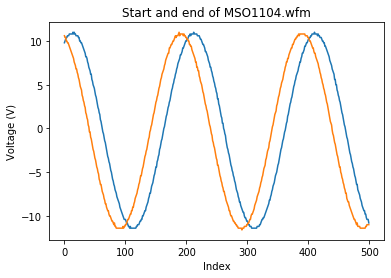

In [4]:
plt.plot(channels[0].volts[:500])
plt.plot(channels[0].volts[-500:])

plt.xlabel("Index")
plt.ylabel("Voltage (V)")

plt.title("Start and end of MSO1104.wfm")
plt.show()

And finally, a graph with the real time units.

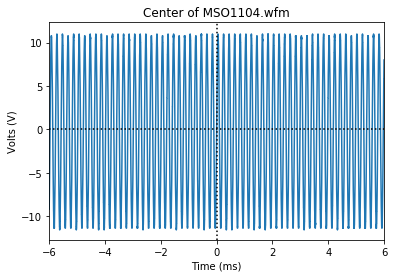

In [5]:
plt.plot(channels[0].times*1e3, channels[0].volts)
plt.xlabel("Time (ms)")
plt.ylabel("Volts (V)")
plt.xlim(-6,6)
plt.title("Center of MSO1104.wfm")
plt.axhline(0,ls=':',color='k')
plt.axvline(0,ls=':',color='k')

plt.show()

## Example of three trace waveform

This `.wfm` file has an accompanying `.csv` file.  The difference between these two files is that the `.csv` file has been downsampled to 1200 points.  The `.wfm` has 3000128 bytes.

<img src="https://user-images.githubusercontent.com/43404500/45744052-0b897080-bbed-11e8-8d96-d46fd7e4c9c7.png" width="170%">

Here we just validate that the `.csv` file has the same values

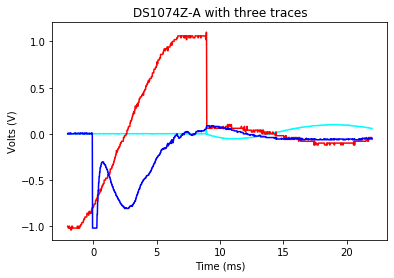

In [6]:
csv_filename = "https://github.com/scottprahl/RigolWFM/raw/master/wfm/DS1074Z-A.csv"

csv_data = np.genfromtxt(csv_filename, delimiter=',', skip_header=2).T

# these are from the second line of the .csv file
t_start = -2.000000e-03  # seconds
t_incr = 2.000000e-05    # seconds/point

# construct times for each point
csv_times = csv_data[0] * t_incr + t_start

plt.plot(csv_times*1000, csv_data[1],color='cyan')
plt.plot(csv_times*1000, csv_data[2],color='red')
plt.plot(csv_times*1000, csv_data[3],color='blue')

plt.xlabel("Time (ms)")
plt.ylabel("Volts (V)")
plt.title("DS1074Z-A with three traces")
plt.show()

In [7]:
wfm_filename = "https://github.com/scottprahl/RigolWFM/raw/master/wfm/DS1074Z-A.wfm" + "?raw=true"  

channels = wfme.read_and_parse_file(wfm_filename, kind='1000Z')

for ch in channels:
    print(ch)

working on https://github.com/scottprahl/RigolWFM/raw/master/wfm/DS1074Z-A.wfm?raw=true
downloading file
Channel 1
    Enabled:   True
    Voltage:
        Scale  = 50 mV/div
        Offset = 0 V
    Time:
        Scale  = 2 ms/div
        Delay  = 10 ms
        Delta  = 8 ns/point
    Data:
        Points = 3000128
        Raw    = [      115,      115,      115  ...       140,      140]
        Volts  = [   -24 mV,   -24 mV,   -24 mV  ...     26 mV,    26 mV]
        Times  = [-2.00051 ms,-2.0005 ms,-2.0005 ms  ... 22.0005 ms,22.0005 ms]

Channel 2
    Enabled:   True
    Voltage:
        Scale  = 500 mV/div
        Offset = 0 V
    Time:
        Scale  = 2 ms/div
        Delay  = 10 ms
        Delta  = 8 ns/point
    Data:
        Points = 3000128
        Raw    = [       54,       53,       54  ...        88,       88]
        Volts  = [  -1.46 V,  -1.48 V,  -1.46 V  ...   -780 mV,  -780 mV]
        Times  = [-2.00051 ms,-2.0005 ms,-2.0005 ms  ... 22.0005 ms,22.0005 ms]

Channel 3


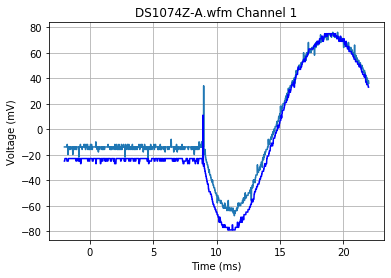

In [13]:
avg = np.mean(channels[0].volts[::2500])

plt.plot(channels[0].times[::2500]*1000, (channels[0].volts[::2500]-avg)*1000)
plt.plot(csv_times*1000, csv_data[1]*1000-25,color='blue')

plt.xlabel("Time (ms)")
plt.ylabel("Voltage (mV)")
plt.grid(True)
plt.title("DS1074Z-A.wfm Channel 1")
plt.show()

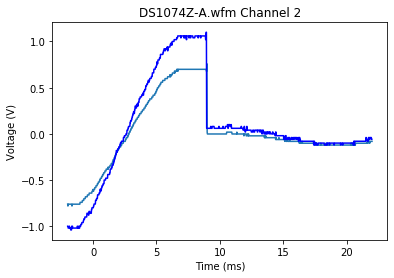

In [14]:
avg = np.mean(channels[1].volts[::2500])
plt.plot(channels[1].times[::2500]*1000, channels[1].volts[::2500]-avg)
plt.plot(csv_times*1000, csv_data[2],color='blue')

plt.xlabel("Time (ms)")
plt.ylabel("Voltage (V)")

plt.title("DS1074Z-A.wfm Channel 2")
plt.show()

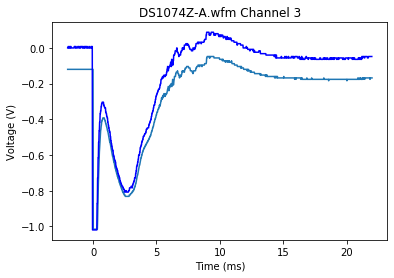

In [15]:
plt.plot(channels[2].times[::2500]*1000, channels[2].volts[::2500])
plt.plot(csv_times*1000, csv_data[3],color='blue')

plt.xlabel("Time (ms)")
plt.ylabel("Voltage (V)")

plt.title("DS1074Z-A.wfm Channel 3")
plt.show()